# Phase cube

A phase cube is computed from a scan of a flat source. 
It is used to:
* obtain an order 0 phase map when the target is too bright to compute a reliable internal phase
* obtain a high order phase

job file:
```
WAVENUMBER 1
WAVE_CALIB 1
APOD 1.0
CALIBMAP LASER_None.cam1.calibration_laser_map.fit.fits
OBS data/ar42/19aq65/2392276c.fits
OBS data/ar42/19aq65/2392277c.fits
OBS data/ar42/19aq65/2392278c.fits
OBS data/ar42/19aq65/2392279c.fits
OBS data/ar42/19aq65/2392280c.fits
OBS data/ar42/19aq65/2392281c.fits
OBS data/ar42/19aq65/2392282c.fits
OBS data/ar42/19aq65/2392283c.fits
OBS data/ar42/19aq65/2392284c.fits
OBS data/ar42/19aq65/2392285c.fits
OBS data/ar42/19aq65/2392335c.fits
OBS data/ar42/19aq65/2392336c.fits
OBS data/ar42/19aq65/2392337c.fits
OBS data/ar42/19aq65/2392338c.fits
OBS data/ar42/19aq65/2392339c.fits
```

command:
```bash
orbs sitelle phase.job start --flat
```

outputs:
* high order phase file: `flats_SN2.cam1.Interferogram.high_order_phase.hdf5`
* phase maps: `flats_SN2.cam1.BinnedPhaseCube.phase_maps.iter0.hdf5`


phase is considered as a polynomial of arbitrary high degree 

$\phi (\sigma) = p_0 + p_1\sigma + p_2(\sigma)$

* $p_0$ is a map which depends on the indident angle and may change from one cube to the other (but not too much so that maps obtained with a phase cube can be used when this map cannot be computed from the science cube)
* $p_1$ is a coefficient which may change for each cube (depends on the exact position of the sampling wrt to the ZPD)
* $p_2$ is a function of $\sigma$ only. It is computed from a phase cube and is not expected to change during a run.

Phase computation is done in two fit iterations on a binned phase cube. During the first iteration both the order 0 and 1 are free, but only the order 1 is measured. An estimation is made based on the median of its distribution and used as a fixed parameter during the second iteration. A map of order 0 is thus obtained and a model is used to smooth it. The model is of the form: $\alpha + \beta \cos (\theta)$ where $\theta$ is the incident angle.

## high order phase file

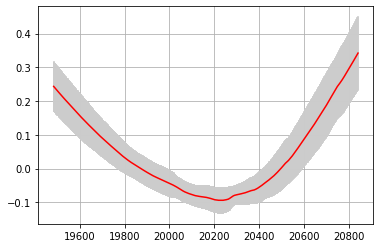

In [12]:
import orbs.phase
import orb.fft
import pylab as pl
import numpy as np
import logging
logging.getLogger().setLevel(logging.INFO)

phase = orb.fft.Phase('/reductions2/sitelle/phase/SN2/flats_SN2.cam1.Interferogram.high_order_phase.hdf5')
phase = phase.cleaned()
pl.errorbar(phase.axis.data, phase.data, yerr=phase.err, ls='none', c='0.8')
phase.plot(c='red')
pl.grid()


## what is the effect of a phase error on the measured parameters ?

Text(0, 0.5, 'centroid error (% of fwhm)')

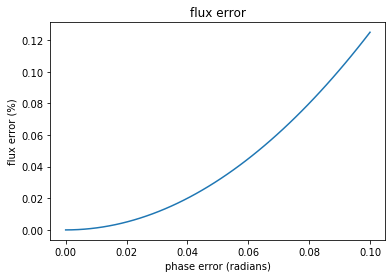

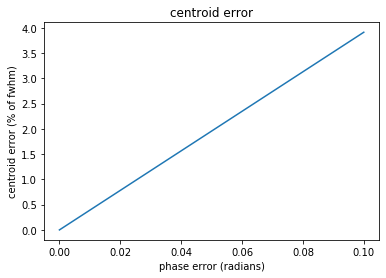

In [13]:
def flux_error(ph_err):
    """ph_err in radians"""
    return 100 *(1 - np.cos(ph_err/2))

def centroid_error(ph_err):
    """ph_err in radians"""
    return 39.1 * ph_err

ph_err = np.linspace(0,0.1)

pl.plot(ph_err, flux_error(ph_err))
pl.title('flux error')
pl.xlabel('phase error (radians)')
pl.ylabel('flux error (%)')

pl.figure()
pl.plot(ph_err, centroid_error(ph_err))
pl.title('centroid error')
pl.xlabel('phase error (radians)')
pl.ylabel('centroid error (% of fwhm)')

## 0th order phase map

0th order phase map is obtained after at least 2 fit iterations, since the order 1 coefficent must be obtained from the preceding fit and fixed at the last iteration.

INFO:root:Phase maps loaded : order 1, shape (341, 344), binning 6


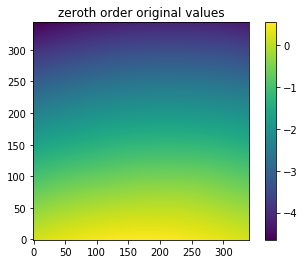

In [23]:
# last iteration phase maps must be used to see the values of the order 0 (iter0)
pm = orb.fft.PhaseMaps('/reductions2/sitelle/phase/SN2/flats_SN2/CAM1/flats_SN2.cam1.BinnedPhaseCube.phase_maps.iter0.hdf5')
pm0_orig = pm.get_map(0)
pl.imshow(pm0_orig.T, origin='bottom')
pl.title('zeroth order original values')
pl.colorbar()

INFO:root:p: [-135.64665581  138.97651275] | modeling error: 0.024760179697693604 rad


Text(0.5, 1.0, 'Resisual on the zeroth order fit')

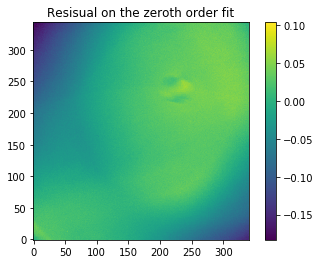

In [15]:
pm.modelize() # replace orginal results with a model
pm0_model = pm.get_map(0)
res = pm0_orig - pm0_model
pl.imshow(res.T, origin='bottom')
pl.colorbar()
pl.title('Resisual on the zeroth order fit')

## order 1 coefficient

In [16]:
# first iteration phase maps must be used to see the values of the order 1 (iter1)
pm = orb.fft.PhaseMaps('/reductions2/sitelle/phase/SN2/flats_SN2/CAM1/flats_SN2.cam1.BinnedPhaseCube.phase_maps.iter1.hdf5')

INFO:root:Phase maps loaded : order 1, shape (341, 344), binning 6


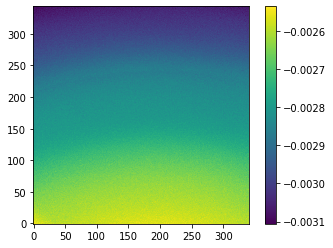

In [17]:
pm1 = pm.get_map(1)
pl.imshow(pm1.T, origin='bottom')
pl.colorbar()

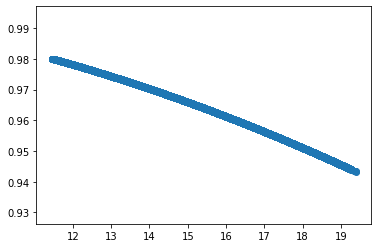

In [18]:
pl.scatter(pm.theta_map.flatten(), np.cos(np.deg2rad(pm.theta_map.flatten())))

(-0.003105922354569809, -0.002535216504706751)

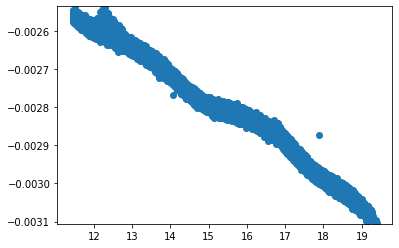

In [19]:
pl.scatter(pm.theta_map.flatten(), pm1.flatten())
pl.ylim((np.min(pm1), np.max(pm1)))

(-0.003105922354569809, -0.002535216504706751)

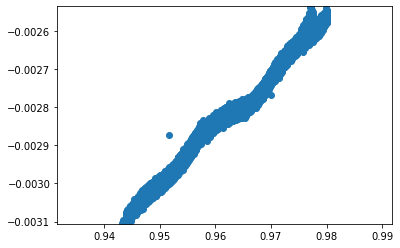

In [20]:
pl.scatter(np.cos(np.deg2rad(pm.theta_map.flatten())), pm1.flatten())
pl.ylim((np.min(pm1), np.max(pm1)))

INFO:root:p: [-0.01652965  0.01424434] | modeling error: 1.3405008509084767e-05 rad


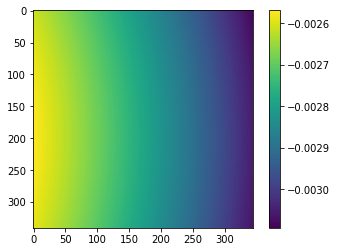

In [21]:
fitted, residual = orb.utils.image.fit_phase_map(pm1, np.ones_like(pm1)*1e-12, pm.theta_map)
pl.imshow(fitted)
pl.colorbar()

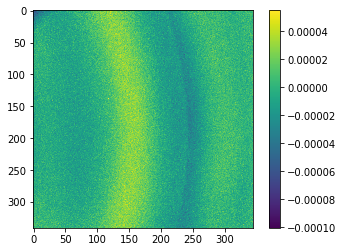

In [22]:
pl.imshow(residual)
pl.colorbar()

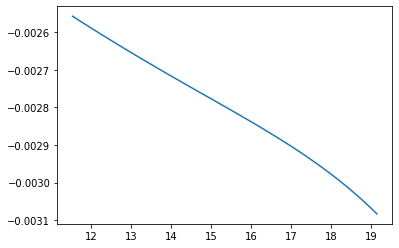

In [24]:
thetas, pm1_model, pm1_err = orb.utils.image.fit_map_theta(pm1, np.zeros_like(pm1), np.cos(np.deg2rad(pm.theta_map)))
pl.plot(np.rad2deg(np.arccos(thetas)), pm1_model(thetas))

In [49]:
model = orb.utils.io.read_fits('/reductions2/sitelle/phase/SN2/flats_SN2/CAM1/flats_SN2.cam1.Interferogram.phase_cube_model.fits')

In [50]:
pcube = orbs.phase.BinnedPhaseCube('/reductions2/sitelle/phase/SN2/flats_SN2/CAM1/flats_SN2.cam1.Interferogram.binned_phase_cube.hdf5')
pcube.params['calibration_laser_map_path'] = '/reductions2/sitelle/phase/SN2/LASER_None.cam1.calibration_laser_map.fit.fits'

In [51]:
hop = orb.fft.Phase(orb.core.Tools()._get_phase_file_path('SN2'))

In [52]:
data = pcube[:,:,:]
res = data - model - hop.project(phase.axis).data
#pl.plot(phase.data - model[150,150,:] - hop.project(phase.axis).data)
#pl.xlim(phase.get_filter_bandpass_pix())


In [53]:
import numpy as np

In [54]:
zmin, zmax = phase.get_filter_bandpass_pix()
res[:,:,:zmin] =np.nan
res[:,:,zmax:] =np.nan

/home/thomas/miniconda2/envs/orb3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


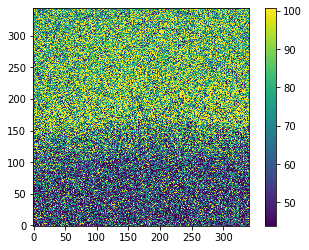

In [55]:
frame = res[:,:,1400]
pl.imshow(frame.T, vmin=np.nanpercentile(frame,10), vmax=np.nanpercentile(frame,90),origin='bottom')
pl.colorbar()

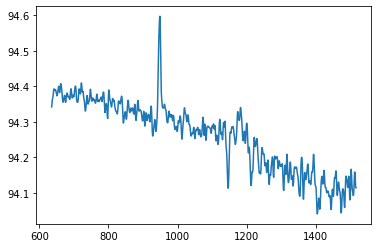

In [56]:
pl.plot(res[200,330,:])